# Reproducibility notebook

This notebook was used to generate and compile the results used in the MicroSSIM paper. 
Rather than showcasing how to use the library, this notebook calls inner functions. For
example on how to use the library, refer to the README.

Some of the images or numbers generated in this notebook might be slightly different
from those presented in the paper, this will be the case every time that we used 
random choices of image within the dataset or region of interest within an image 
without setting a seed. This does not alter the validity of the results, it just 
presents the same results on a different image or a different region of the image.

In [1]:
from collections import defaultdict
from pathlib import Path

import numpy as np

# data download and io
from tifffile import imread
import pooch

# plotting libraries and user feedback
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
from tqdm import tqdm
import pandas as pd

# microssim imports
from microssim import MicroSSIM, MicroMS3IM
from microssim.micro_ssim import _compute_micro_ssim
from microssim.ri_factor import get_global_ri_factor
from microssim.ssim import ScaledSSIM, compute_scaled_ssim, compute_ssim_elements
from microssim.image_processing.care_normalization import normalize_care, normalize_min_mse
from microssim.image_processing import normalize_min_max

# helper functions defined in the utils module
from utils import (
    add_pixel_kde, 
    clean_ax, 
    add_subplot_axes, 
    add_text,
    boundary_color,
    get_zoomin_hw
)

In [2]:
# Define some global parameters
debug_mode = True
BACKGROUND_PERCENTILE = 3
path_imgs = Path("figures")
rng = np.random.default_rng(42)

## Load data

We use the data from Hagen et al. (2021), originally published [here](https://doi.org/10.5524/100888).

All data can be downloading in the `0-download_data.ipynb` notebook.

In [3]:
# If it has already been downloaded, it will simply return the path to the file
# without downloading it again (provided that the paths are the same)
noisy_gt_path = pooch.retrieve(
    url="https://download.fht.org/jug/microssim/N2V/Actin/actin-60x-noise2-lowsnr.tif",
    known_hash="8f9ee6e14e348e52c6fa5b05bce8a253981d81004870380d21cc37343b562fff",
    path = "data"
)

gt_path = pooch.retrieve(
    url="https://download.fht.org/jug/microssim/N2V/Actin/gt-N2V-2402-31.tif",
    known_hash="55bf2bebfe88eb52d6e82db68f3492b78a7cf22b544b93b11c18a578d189560d",
    path = "data"
)

pred_path = pooch.retrieve(
    url="https://download.fht.org/jug/microssim/N2V/Actin/pred-N2V-2402-31.tif",
    known_hash="67db7a5e7ca6a83cf29b24145bd97efddf4436bcee417f5098afcbd5bfd36f0c",
    path = "data"
)

In [4]:
# Load data
gt = imread(gt_path)
pred = imread(pred_path)
gt_lowsnr = imread(noisy_gt_path)

print(f"Ground-truth shape {gt.shape}")
print(f"Prediction shape {pred.shape}")
print(f"Low SNR shape {gt_lowsnr.shape}")

Ground-truth shape (100, 2048, 2048)
Prediction shape (100, 2048, 2048)
Low SNR shape (100, 2048, 2048)


## Background estimation

By default, MicroSSIM uses simple background estimation based on the percentile. We 
usually use a `bg_percentile = 3%`.

In [5]:
# Compute the background level of the prediction and ground-truth
BACKGROUND_OFFSET_PREDICTION = np.percentile(pred, BACKGROUND_PERCENTILE, keepdims=False)
BACKGROUND_OFFSET_TARGET = np.percentile(gt, BACKGROUND_PERCENTILE, keepdims=False)

print(f'Background offset for prediction: {BACKGROUND_OFFSET_PREDICTION}')
print(f'Background offset for target: {BACKGROUND_OFFSET_TARGET}')

Background offset for prediction: 102.82351684570312
Background offset for target: 102.0


## Dataset level scaling factor

MicroSSIM normalization removes the background offset and normalizes the data using
the maximimum value of the ground-truth (after background removal).

MicroSSIM uses a scaling factor after normalization to scale the prediction to the 
ground-truth range. The scaling factor is estimated so as to maximize the SSIM score.

In [6]:
# Remove the background offset from the ground-truth and compute the max
gt_all_norm = gt - BACKGROUND_OFFSET_TARGET
all_max = gt_all_norm.max()

# Normalize the ground-truth and prediction using their background values
gt_all_norm = normalize_min_max(gt, BACKGROUND_OFFSET_TARGET, all_max)
pred_all_norm = normalize_min_max(pred, BACKGROUND_OFFSET_PREDICTION, all_max)

# Compute the scaling factor using every four image
MICROSSIM_SCALE = get_global_ri_factor(gt_all_norm[::4], pred_all_norm[::4])
print(f"Scaling factor: {MICROSSIM_SCALE}")

100%|██████████| 25/25 [00:12<00:00,  2.02it/s]


Scaling factor: 14.575401287368317


## Comparing various data normalization.

In [7]:
# TODO find the indices of the images used in the paper in fig 2
idx = 91 # rng.integers(0, gt.shape[0])
print(f"Image index: {idx}")

# Images without any normalization. 
gt_tmp = gt[idx]
pred_tmp = pred[idx]

# Zero mean and unit variance normalization
gt_norm_meanstd = (gt_tmp - gt_tmp.mean())/gt_tmp.std()
pred_norm_meanstd = (pred_tmp - pred_tmp.mean())/pred_tmp.std()

# CARE-based normalization (adapted from the CSBDeep library)
gt_norm_CARE = normalize_care(gt_tmp.copy())
pred_norm_CARE = normalize_min_mse(pred_tmp.copy(), gt_norm_CARE)

# MicroSSIM normalization (remove background and normalize by max)
pred_norm_microssim = normalize_min_max(pred_tmp.copy(), BACKGROUND_OFFSET_PREDICTION, all_max)
gt_norm_microssim = normalize_min_max(gt_tmp.copy(), BACKGROUND_OFFSET_TARGET, all_max)

Image index: 91


In [8]:
# Compute SSIM (equivalent to MicroSSIM with ri_factor=1.0) components
# The result of _compute_micro_ssim is a dataclass containing all the SSIM components
# (ux, uy, vx, vy, vxy, c1, c2, luminance, contrast, structure, ssim)
ssim_comp_unnormalized = _compute_micro_ssim(
    gt_tmp, 
    pred_tmp, 
    ri_factor=1.0,
    data_range=gt_tmp.max() - gt_tmp.min(), 
    return_individual_components=True
)

ssim_comp_meanstd_norm = _compute_micro_ssim(
    gt_norm_meanstd, 
    pred_norm_meanstd, 
    ri_factor=1.0,  
    data_range=gt_norm_meanstd.max() - gt_norm_meanstd.min(), 
    return_individual_components=True
)

ssim_comp_care_norm = _compute_micro_ssim(
    gt_norm_CARE, 
    pred_norm_CARE, 
    ri_factor=1.0,
    data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), 
    return_individual_components=True
)

ssim_comp_microssim_norm = _compute_micro_ssim(
    gt_norm_microssim, 
    pred_norm_microssim, 
    ri_factor=MICROSSIM_SCALE,
    data_range=gt_norm_microssim.max() - gt_norm_microssim.min(), 
    return_individual_components=True
)

## Noisy, prediction, and ground-truth dynamical ranges (fig 1)

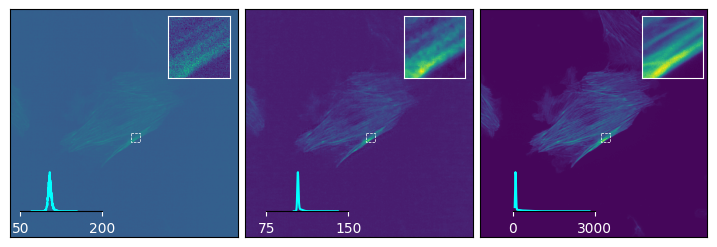

In [9]:
# Define some parameters for the plots and debugging
save_to_file = False and not debug_mode

def plot_raw_images(ind, save=False, img_name=""):
    _, ax = plt.subplots(figsize=(9,3), ncols=3)

    ax[0].imshow(gt_lowsnr[ind])
    ax[1].imshow(pred[ind])
    ax[2].imshow(gt[ind])

    # zoom-in rectangles
    zoom_in_h, zoom_in_w = get_zoomin_hw(gt[ind], seed=42)
    zoom_in_size = 80

    for i in range(3):
        ax[i].add_patch(
            patches.Rectangle(
                (zoom_in_w, zoom_in_h), 
                zoom_in_size,
                zoom_in_size, 
                linewidth=0.5, 
                edgecolor='w', 
                facecolor='none', 
                linestyle='--'
            )
        )

    # zoom-in patches (using functions defined in the utils module)
    zoom_in_rects = [
        [0.77, 0.72, 0.3, 0.3],
        [0.72, 0.72, 0.3, 0.3],
        [0.68, 0.72, 0.3, 0.3] # prevents overflowing at the figure border
    ]
    imgs = [
        gt_lowsnr,
        pred,
        gt
    ]
    for i, (z_rect, im) in enumerate(zip(zoom_in_rects, imgs)):
        zoom_in_ax = add_subplot_axes(
            ax[i], 
            z_rect, 
            facecolor = 'w', 
            min_labelsize = 5
        )
        zoom_in_ax.imshow(im[idx][zoom_in_h:zoom_in_h+zoom_in_size,zoom_in_w:zoom_in_w+zoom_in_size])
        clean_ax(zoom_in_ax)
        boundary_color(zoom_in_ax, 'white')


    # Add density plots
    color_ch = 'cyan'
    inset_min_labelsize = 10
    hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
    fac = 4

    for i, im in enumerate(imgs):
        add_pixel_kde(ax[i],
                    hist_inset_rect,
                    [im[idx][::fac,::fac]],
                    inset_min_labelsize,
                    color_list=[color_ch],
                    label_list = [''])

    # Remove axes
    clean_ax(ax)

    # Adjust plots
    plt.subplots_adjust(wspace=0.03, hspace=0.03)

    # Save to disk
    if save:
        if not path_imgs.exists():
            path_imgs.mkdir()

        postfix = Path(gt_path).name.replace('gt-','').replace('.tif','.png')
        fname = f'{img_name}{ind}_{postfix}'
        fpath = path_imgs / fname
        print(fpath)

        plt.savefig(fpath, dpi=200)

plot_raw_images(idx, save_to_file, 'raw_prediction_Idx')

## SSIM components vs normalizations (fig 2)

Here, we plot the SSIM components (luminence, contrast, structure) for various normalizations.

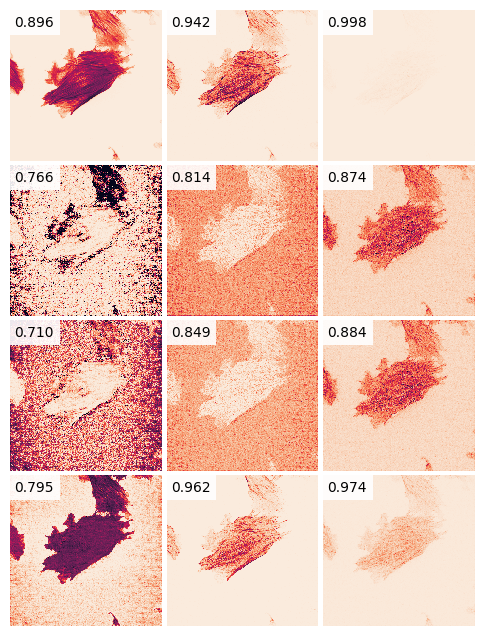

In [10]:
fac = 2 if save_to_file else 4

def plot_ssims(
        ssim_list: list[ScaledSSIM], 
        fac, 
        save=False, 
        img_name="",
        title=False,
        row_text: list[str] = None,
        ind: int = -1, 
):
    shape = ssim_list[0].luminance.shape
    img_size = 2
    _, ax = plt.subplots(figsize=(img_size*3, img_size*len(ssim_list)), ncols=3, nrows=len(ssim_list))

    for i, ssim in enumerate(ssim_list): # loop over ssims
        comps = [
            ssim.luminance,
            ssim.contrast,
            ssim.structure
        ]
        
        for j, comp in enumerate(comps): # loop over SSIM components
            sns.heatmap(comp[::fac, ::fac], vmin=0, vmax=1, ax=ax[i,j], cbar=False)
            val = f"{comp[::fac, ::fac].mean():.3f}"
            add_text(ax[i, j], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    if title:
        ax[0, 0].set_title('Luminance'.upper())
        ax[0, 1].set_title('Contrast'.upper())
        ax[0, 2].set_title('Structure'.upper())

    if row_text is not None:
        for i, txt in enumerate(row_text):
            alpha_true = round(ssim_list[i].alpha, 2)
            ax[i, 0].set_ylabel(f'{txt}\n$\\alpha={alpha_true}$', fontsize=12)

    clean_ax(ax)

    plt.subplots_adjust(wspace=0.03, hspace=0.03)

    if save:
        if not path_imgs.exists():
            path_imgs.mkdir()

        postfix= Path(gt_path).name.replace('gt-','').replace('.tif','.png')
        fname = f'{img_name}{ind}_{postfix}'
        fpath = path_imgs / fname
        print(fpath)
        plt.savefig(fpath, dpi=200)


ssims = [
    ssim_comp_unnormalized,
    ssim_comp_meanstd_norm,
    ssim_comp_care_norm,
    ssim_comp_microssim_norm
]
plot_ssims(ssims, fac, save_to_file, img_name="baseline_comparison_Idx", ind=idx)

## Inspecting background removal (fig 4)

In order to compare the effect of background removal, we perform normalization in
the following ways:
- removing the background and dividing by the maximum value
- solely dividing by the maximal value
- removing the mean and dividing by the maximal value. 

In [11]:
def normalize_bg_ablation(img: np.ndarray, method: str, is_gt: bool) -> np.ndarray:
    max_val = all_max
    
    if method == NORM_MINMAX:
        min_val = (
            BACKGROUND_OFFSET_TARGET
            if is_gt
            else BACKGROUND_OFFSET_PREDICTION
        )
    elif method == NORM_MEANMAX:
        min_val = img.mean()
    else:
        min_val = 0

    return normalize_min_max(img, min_val, max_val)

# Indices on which to compute the MicroSSIM components
idx_list  = list(range(0, 100, 10))

# Keys used to store the various normalization results
NORM_MINMAX = "MinMax" # bg removal = True
NORM_MAX = "Max" # bg removal = False
NORM_MEANMAX = "MeanMax" # bg removal = mean

# Loop over the indices
dict_bg_ablation = defaultdict(list)
for idx in tqdm(idx_list):

    for remove_bg in [NORM_MINMAX, NORM_MAX, NORM_MEANMAX]:

        gt_tmp = normalize_bg_ablation(gt[idx], remove_bg, is_gt=True)
        pred_tmp = normalize_bg_ablation(pred[idx], remove_bg, is_gt=False)

        ssim_comp = _compute_micro_ssim(
            gt_tmp, 
            pred_tmp, 
            ri_factor=None, 
            data_range=gt_tmp.max() - gt_tmp.min(), 
            return_individual_components=True
        )

        dict_bg_ablation[remove_bg].append(ssim_comp)
        
        assert np.allclose(ssim_comp.SSIM, (ssim_comp.luminance * ssim_comp.contrast * ssim_comp.structure))

100%|██████████| 10/10 [01:34<00:00,  9.47s/it]


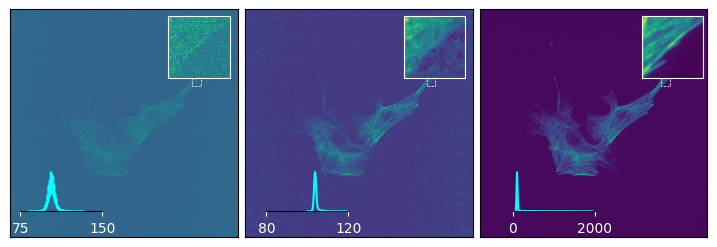

In [12]:
save_to_file = False and not debug_mode

# Index to plot
ith_img= 8
idx = idx_list[ith_img]

# Plot cells
plot_raw_images(idx, save_to_file, 'bkg_ablation_Idx')

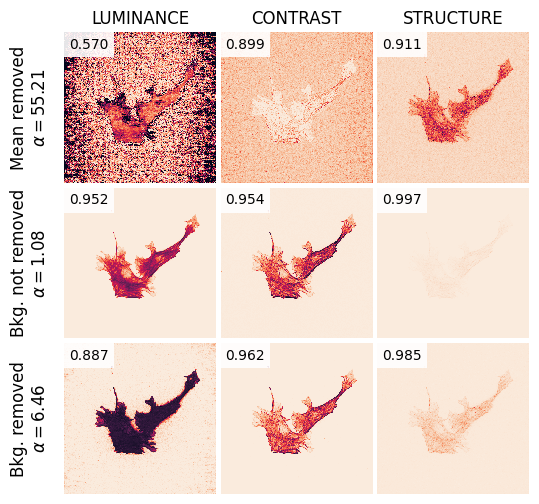

In [13]:
fac = 2 if save_to_file else 4

ssims = [
    dict_bg_ablation[NORM_MEANMAX][ith_img],
    dict_bg_ablation[NORM_MAX][ith_img],
    dict_bg_ablation[NORM_MINMAX][ith_img],
]
titles = [
    "Mean removed",
    "Bkg. not removed",
    "Bkg. removed"
]

plot_ssims(ssims, fac, save_to_file, img_name="bkg_ablation_Idx", ind=idx, title=True, row_text=titles)


## Manually varying alpha to inspect its uniqueness (supp fig 2)

In [30]:
save_to_file = True and not debug_mode

ssim_components = defaultdict(list)
idx_list = []
alpha_list = np.concatenate([np.arange(0, 300)])

# Randomly choose 30 images and compute the SSIM components for each alpha
for idx in rng.choice(len(gt), size=30, replace=False):
    idx_list.append(idx)

    # normalize images
    gt_cur = normalize_min_max(gt[idx], BACKGROUND_OFFSET_TARGET, all_max)
    pred_cur = normalize_min_max(pred[idx], BACKGROUND_OFFSET_PREDICTION, all_max)

    # compute SSIM elements
    ssim_elements = compute_ssim_elements(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min()
    )

    # for each alpha, compute the scaled SSIM
    ssim_arr = []
    for factor in tqdm(alpha_list):
        ssim_arr.append(
            compute_scaled_ssim(ssim_elements, alpha=factor)
        )
    
    ssim_components['ssim'].append(ssim_arr)    

100%|██████████| 300/300 [00:41<00:00,  7.31it/s]


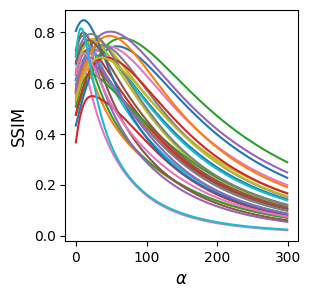

In [32]:
# Plot SSIM vs alpha
_, ax = plt.subplots(figsize=(3,3))

pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)

ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)

if save_to_file:
    postfix = Path(gt_path).name.replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = path_imgs / fname
    print(fpath)

    plt.tight_layout()
    plt.savefig(fpath, dpi=200)

## SSIM factor saturation (fig 3)

In [16]:
def luminance_without_C1(alpha, ux, uy):
    num = 2 * alpha * ux * uy
    den = ux**2 + (alpha**2) * uy**2
    return num, den

def contrast_without_C2(alpha, vx, vy):
    num = 2 * alpha * np.sqrt(vx * vy)
    den = vx + (alpha**2) * vy
    return num, den

def structure_without_C2(alpha, vx, vy, vxy):
    num = 2 * alpha * vxy
    den = 2 * alpha * np.sqrt(vx * vy + 1e-10)
    return num, den

def get_multiplicative_factor_to_C(ssim_vals: ScaledSSIM):

    alpha = ssim_vals.alpha
    num_luminance, den_luminance = luminance_without_C1(alpha, ssim_vals.elements.ux, ssim_vals.elements.uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, ssim_vals.elements.vx, ssim_vals.elements.vy)
    num_structure, den_structure = structure_without_C2(alpha, ssim_vals.elements.vx, ssim_vals.elements.vy, ssim_vals.elements.vxy)

    C1 = ssim_vals.elements.C1
    C2 = ssim_vals.elements.C2

    luminance_factors = np.minimum(np.abs(C1/num_luminance), np.abs(C1/den_luminance)).mean()
    contrast_factors = np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)).mean()
    structure_factors = np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)).mean()

    return luminance_factors, contrast_factors, structure_factors


def _saturation_ablation_normalization(norm_mode, img, bkg_remove_fn):
    if norm_mode == 'microSSIM':
        img_out = bkg_remove_fn(img)
    elif norm_mode in ['no_downscale', 'microSSIM_no_downscale']:
        img_out = img - BACKGROUND_OFFSET_TARGET
        assert abs(BACKGROUND_OFFSET_TARGET - BACKGROUND_OFFSET_PREDICTION) < 2, 'Change this logic then, you are assuming both are same'
    elif norm_mode == 'downscale':
        img_out = bkg_remove_fn(img)
    elif norm_mode == 'no_bkg_rmv':
        img_out = img
    elif norm_mode == 'instance_pred_bkg_rmv':
        img_out = img - np.percentile(img, BACKGROUND_PERCENTILE, keepdims=False)
    else:
        raise ValueError(f'Invalid value for norm_mode: {norm_mode}')
    return img_out

In [18]:
# TODO stopped refactoring here
def microSSIM_pred_norm(data):
    data = data - BACKGROUND_OFFSET_PREDICTION
    # return data
    return data / all_max

def microSSIM_gt_norm(data):
    data = data - BACKGROUND_OFFSET_TARGET
    # return data
    return data / all_max

correct_pred_factorsdict = defaultdict(lambda: defaultdict(list))
random_pred_factorsdict = defaultdict(lambda: defaultdict(list))
nsamples = 30
for norm_mode in ['no_bkg_rmv','instance_pred_bkg_rmv', 'no_downscale', 'downscale', 'microSSIM']:
    for idx in tqdm(range(nsamples)):
        gt_norm_mode = norm_mode
        if norm_mode == 'instance_pred_bkg_rmv':
            gt_norm_mode = 'no_downscale'
        
        gt_tmp = _saturation_ablation_normalization(gt_norm_mode, gt[idx], microSSIM_gt_norm)
        pred_tmp = _saturation_ablation_normalization(norm_mode, pred[idx], microSSIM_pred_norm) 
        ssim_comp_unnormalized = _compute_micro_ssim(
            gt_tmp, 
            pred_tmp, 
            ri_factor=MICROSSIM_SCALE if norm_mode=='microSSIM' else 1.0,
            data_range=gt_tmp.max() - gt_tmp.min(), 
            return_individual_components=True
        )
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_comp_unnormalized)
        
        correct_pred_factorsdict[norm_mode]['luminance'].append(luminance_factors)
        correct_pred_factorsdict[norm_mode]['contrast'].append(contrast_factors)
        correct_pred_factorsdict[norm_mode]['structure'].append(structure_factors)
        correct_pred_factorsdict[norm_mode]['SSIM'].append(ssim_comp_unnormalized.SSIM.mean())


    for idx in tqdm(range(nsamples)):
        gt_tmp = _saturation_ablation_normalization(gt_norm_mode, gt[idx], microSSIM_gt_norm)
        rand_raw = np.random.rand(*gt_tmp.shape)
        pred_tmp = _saturation_ablation_normalization(norm_mode, rand_raw, microSSIM_pred_norm)

        ssim_comp_unnormalized = _compute_micro_ssim(
            gt_tmp, 
            pred_tmp, 
            ri_factor=MICROSSIM_SCALE if norm_mode=='microSSIM' else 1.0,
            data_range=gt_tmp.max() - gt_tmp.min(), 
            return_individual_components=True
        )
        luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_comp_unnormalized)
        
        random_pred_factorsdict[norm_mode]['luminance'].append(luminance_factors)
        random_pred_factorsdict[norm_mode]['contrast'].append(contrast_factors)
        random_pred_factorsdict[norm_mode]['structure'].append(structure_factors)
        random_pred_factorsdict[norm_mode]['SSIM'].append(ssim_comp_unnormalized.SSIM.mean())



100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


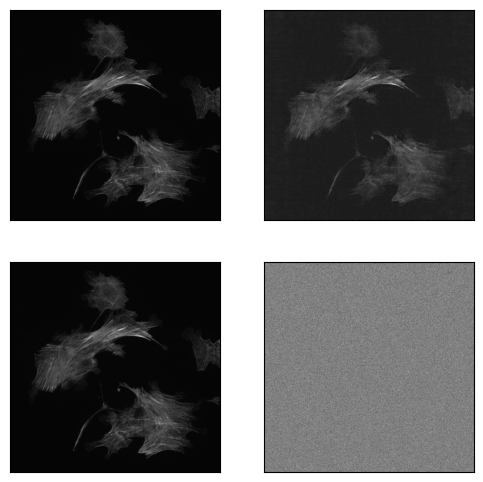

In [19]:
save_to_file = True and not debug_mode
img_size = 3
idx_tmp= 0
_,ax = plt.subplots(figsize=(img_size*2,img_size*2),ncols=2,nrows=2)
ax[0,0].imshow(gt[idx_tmp], cmap='gray')
ax[0,1].imshow(pred[idx_tmp], cmap='gray')
ax[1,0].imshow(gt[idx_tmp], cmap='gray')
ax[1,1].imshow(np.random.rand(*gt_tmp.shape), cmap='gray')
clean_ax(ax)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_downscaling_sample_input_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

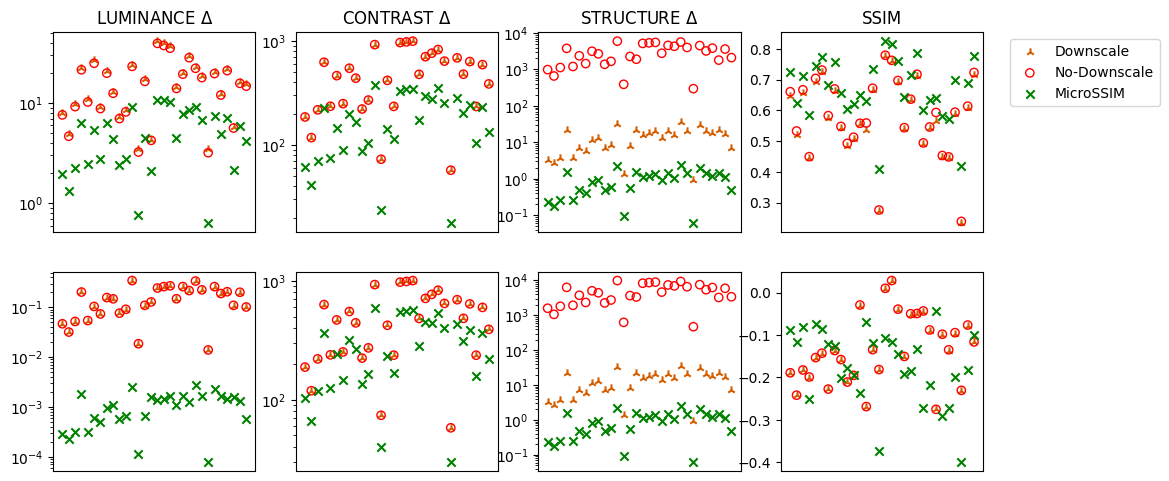

In [21]:
import os
mode = 'downscale' # 'downscale
assert mode in ['background', 'downscale']
_,ax = plt.subplots(figsize=(4*img_size,1.9*img_size),ncols=4,nrows=2)

for col_ix, key in enumerate(['luminance', 'contrast', 'structure', 'SSIM']):
    if mode == 'background':
        # no bkg removal
        df = pd.DataFrame(correct_pred_factorsdict['no_bkg_rmv'][key]).min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='With-bkg.', color='#0072B2', marker='h', facecolors='none')
        df = pd.DataFrame(random_pred_factorsdict['no_bkg_rmv'][key]).min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='With-bkg.', color='#0072B2', marker='h', facecolors='none')

        # no pred bkg removal
        df = pd.DataFrame(correct_pred_factorsdict['instance_pred_bkg_rmv'][key]).min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='Inst-bkg-rm', color='#D55E00', marker='x',)
        df = pd.DataFrame(random_pred_factorsdict['instance_pred_bkg_rmv'][key]).min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='Inst-bkg-rm', color='#D55E00', marker='x',)
    
    elif mode == 'downscale':
        df = pd.DataFrame(correct_pred_factorsdict['downscale'][key]).min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='Downscale', color='#D55E00', marker = '2')
        df = pd.DataFrame(random_pred_factorsdict['downscale'][key]).min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='Downscale', color='#D55E00', marker = '2')

        df = pd.DataFrame(correct_pred_factorsdict['no_downscale'][key]).min(axis=1)
        ax[0,col_ix].scatter(df.index, df.values, label='No-Downscale', color='red', facecolors='none')
        df = pd.DataFrame(random_pred_factorsdict['no_downscale'][key]).min(axis=1)
        ax[1,col_ix].scatter(df.index, df.values, label='No-Downscale', color='red', facecolors='none')


    # microSSIM
    df = pd.DataFrame(correct_pred_factorsdict['microSSIM'][key]).min(axis=1)
    ax[0,col_ix].scatter(df.index, df.values, label='MicroSSIM', color='green', marker='x')
    df = pd.DataFrame(random_pred_factorsdict['microSSIM'][key]).min(axis=1)
    ax[1,col_ix].scatter(df.index, df.values, label='MicroSSIM', color='green', marker='x')

    if key != 'SSIM':
        ax[0,col_ix].set_title(key.upper() + f' $\\Delta$', fontsize=12)
    else:
        ax[0,col_ix].set_title(key.upper(), fontsize=12)

    if key != 'SSIM':
        ax[0,col_ix].set_yscale('log')
        ax[1,col_ix].set_yscale('log')
 
ax[0,3].legend(bbox_to_anchor=(1.1,1.0))
for i in range(2):
    for j in range(4):
        ax[i,j].tick_params(axis='x',which='both',bottom=False, top=False,labelbottom=False) 

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_downscaling_mode-{mode}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

### Background removal for teaser figure.

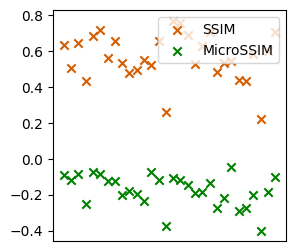

In [22]:
_,ax = plt.subplots(figsize=(3,3))
df = pd.DataFrame(random_pred_factorsdict['instance_pred_bkg_rmv']['SSIM']).min(axis=1)
ax.scatter(df.index, df.values, label='SSIM', color='#D55E00', marker='x',)

df = pd.DataFrame(random_pred_factorsdict['microSSIM'][key]).min(axis=1)
ax.scatter(df.index, df.values, label='MicroSSIM', color='green', marker='x')
ax.legend(loc='upper right')
ax.tick_params(axis='x',which='both',bottom=False, top=False,labelbottom=False) 
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'teaser-benefit_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

## Same experiment, but with MS-SSIM

In [23]:
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure
import torch

msssim = MicroSSIM(offset_pred=BACKGROUND_OFFSET_PREDICTION, offset_gt=BACKGROUND_OFFSET_TARGET, max_val=all_max)
# msssim.fit(gt[::4], pred[::4])
msssim.fit([x for x in gt[::4]], [x for x in pred[::4]])
m3im = MicroMS3IM(**msssim.get_parameters())

nsamples = 30
microms3im_vals = []
msssim_vals = []
for idx in tqdm(range(nsamples)):
    rand_pred_tmp = np.random.rand(*gt[idx].shape)

    microms3im_vals.append(m3im.score(gt[idx], rand_pred_tmp))    

    ms_ssim = MultiScaleStructuralSimilarityIndexMeasure(data_range=gt[idx].max() - gt[idx].min())
    gt_torch = torch.Tensor(gt[idx][None, None]*1.0)
    pred_torch = torch.Tensor(rand_pred_tmp[None, None])
    msssim_vals.append(ms_ssim(pred_torch, gt_torch))


100%|██████████| 30/30 [00:43<00:00,  1.46s/it]


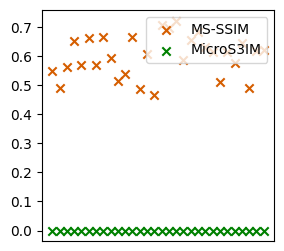

In [24]:
save_to_file = True and not debug_mode
_,ax = plt.subplots(figsize=(3,3))
ax.scatter(np.arange(len(msssim_vals)), msssim_vals, label='MS-SSIM', color='#D55E00', marker='x',)

ax.scatter(np.arange(len(msssim_vals)), microms3im_vals, label='MicroS3IM', color='green', marker='x')
ax.legend(loc='upper right')
ax.tick_params(axis='x',which='both',bottom=False, top=False,labelbottom=False) 
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ms-ssim_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)

## Experiment on how the offset plays a role in performance

In [26]:
import numpy as np
from tqdm import tqdm
idx = np.random.randint(0,len(gt))
enable_ri = False
gt_cur = microSSIM_gt_norm(gt[idx])
pred_cur = microSSIM_pred_norm(pred[idx])
ssim_arr = []
lum_arr = []
con_arr = []
str_arr = []
offset_arr = list(np.arange(-0.1,0.1,0.01))
for offset in tqdm(offset_arr):
    ssim_comp_unnormalized = _compute_micro_ssim(gt_cur + offset , 
                           pred_cur + offset, 
                           ri_factor=MICROSSIM_SCALE if enable_ri else 1.0, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)
    ssim_arr.append(ssim_comp_unnormalized.SSIM.mean())
    lum_arr.append(ssim_comp_unnormalized.luminance.mean())
    con_arr.append(ssim_comp_unnormalized.contrast.mean())
    str_arr.append(ssim_comp_unnormalized.structure.mean())

100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


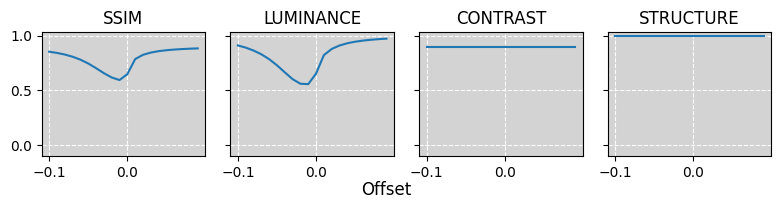

In [27]:
import matplotlib.pyplot as plt
import os
import pandas as pd

save_to_file = True and not debug_mode

fig,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].plot(offset_arr,ssim_arr)
ax[1].plot(offset_arr,lum_arr)
ax[2].plot(offset_arr,con_arr)
ax[3].plot(offset_arr,str_arr)
# ax[3].set_yscale('log')
for ax_ in ax:
    # ax_.set_ylim([0.0,1.1])
    ax_.set_ylim([-0.1,1.03])
    ax_.grid(visible=True, color='w', linestyle='--')
    ax_.set_facecolor('lightgrey')

for ax_ in ax[1:]:
    ax_.set_yticklabels([])


plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0].set_title('SSIM')
ax[1].set_title('LUMINANCE')
ax[2].set_title('CONTRAST')
ax[3].set_title('STRUCTURE')

fig.text(0.5, 0.0, 'Offset', ha='center', fontsize=12)
plt.tight_layout()

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.savefig(fpath, dpi=200)


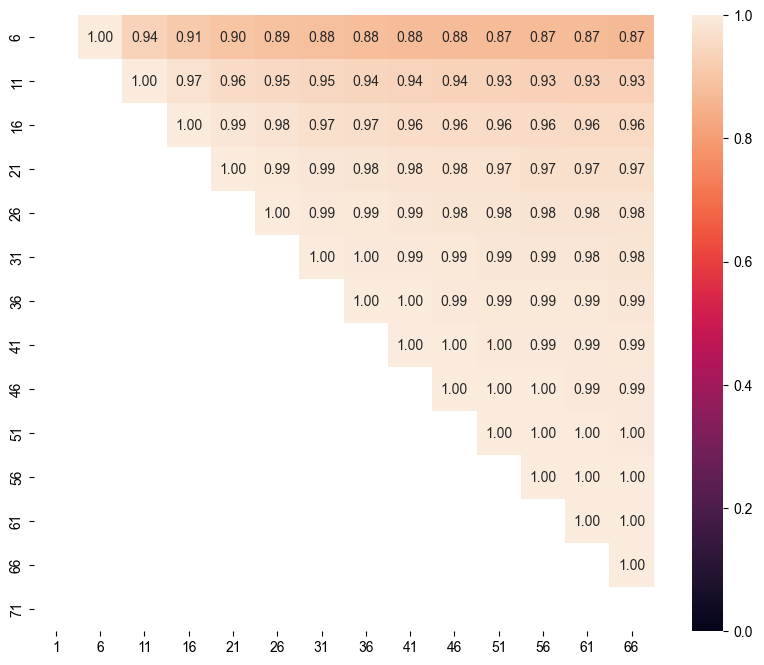

In [28]:
def compute(numerator_factor, denominator_factor):
    if numerator_factor > denominator_factor:
        return np.nan
    return (1 + numerator_factor)/(1 + denominator_factor)


num_factor = np.arange(1, 75, 5)
den_factor = np.arange(1, 75, 5)
num_cor, den_cor = np.meshgrid(num_factor, den_factor)
shape = num_cor.shape
num_cor_fl = num_cor.flatten()
den_cor_fl = den_cor.flatten()
lum = np.array([compute(1/num_cor_fl[i], 1/den_cor_fl[i]) for i in range(num_cor_fl.shape[0])])
lum = lum.reshape(*shape)

# we skip the last numerator and first denominator
lum = lum[1:,:-1]
num_cor = num_cor[1:,:-1]
den_cor = den_cor[1:,:-1]
num_factor = num_factor[:-1]
den_factor = den_factor[1:]
mask = den_cor > num_cor

_, ax = plt.subplots(figsize=(10,8))
df = pd.DataFrame(lum,index=den_factor,columns=num_factor)
# tmp_df = df.loc[df.index[::2]][df.columns[::2]]
sns.heatmap(df, annot=True, mask=mask,vmin=0,vmax=1, fmt=".2f")
sns.set_theme(style='white')
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'synthetic_ablation_C1C2_relevance_plot.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


## Teaser Figure

### Problem

0.013457426110336549
0.637655293587921


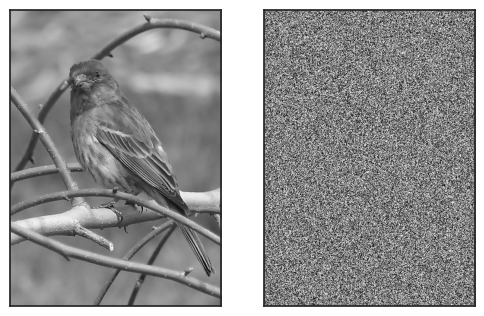

In [30]:
from PIL import Image
def _normalize_teaser(img):
    img = img  - np.percentile(img, BACKGROUND_PERCENTILE, keepdims=False)
    # img = normalizer.normalize(img)
    return img

# def _normalize_teaser(img):
#     img = remove_background(img)
#     # img = normalizer.normalize(img)
#     return img

save_to_file = True and not debug_mode

img=np.array(Image.open('bird.jpeg').convert('L'))
_,ax = plt.subplots(figsize=(6,6),ncols=2)

ax[0].imshow(img,cmap='gray')


norm_img = _normalize_teaser(img)

rand_img = _normalize_teaser(np.random.rand(*img.shape))
ax[1].imshow(rand_img, cmap='gray')
print(_compute_micro_ssim(norm_img, rand_img, ri_factor=1.0, 
                       data_range=norm_img.max() - norm_img.min()))


norm_gt = _normalize_teaser(gt[0])
rand_img = _normalize_teaser(np.random.rand(*gt[0].shape))
print(_compute_micro_ssim(norm_gt, rand_img, ri_factor=1.0, 
                       data_range=norm_gt.max() - norm_gt.min()))

clean_ax(ax)
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'teaser_imagenet.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=100)



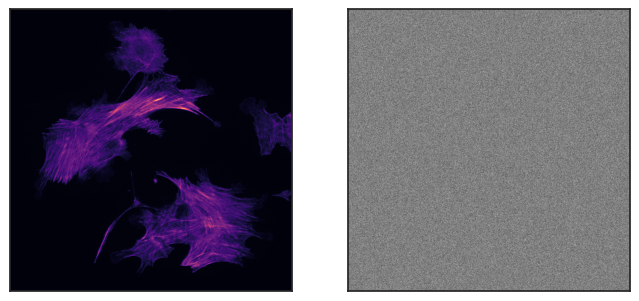

In [31]:
_,ax = plt.subplots(figsize=(8,4),ncols=2)
ax[0].imshow(norm_gt,cmap='magma')
ax[1].imshow(rand_img, cmap='gray')
clean_ax(ax)
if save_to_file:
    # postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'teaser_hagen.png'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=100)


In [34]:
def get_multiplicative_factor_to_C(ssim_dict: ScaledSSIM):
    alpha = ssim_dict.alpha
    num_luminance, den_luminance = luminance_without_C1(alpha, ssim_dict.elements.ux, ssim_dict.elements.uy)
    num_contrast, den_contrast = contrast_without_C2(alpha, ssim_dict.elements.vx, ssim_dict.elements.vy)
    num_structure, den_structure = structure_without_C2(alpha, ssim_dict.elements.vx, ssim_dict.elements.vy, ssim_dict.elements.vxy)

    # luminance_factors = (C1/num_luminance.mean(), C1/den_luminance.mean())
    # contrast_factors = (C2/num_contrast.mean(), C2/den_contrast.mean())
    # structure_factors = (C2/num_structure.mean(), C2/den_structure.mean())
    C1 = ssim_dict.elements.C1
    C2 = ssim_dict.elements.C2
    luminance_factors = np.nanmean(np.minimum(np.abs(C1/num_luminance), np.abs(C1/den_luminance)))
    contrast_factors = np.nanmean(np.minimum(np.abs(C2/num_contrast), np.abs(C2/den_contrast)))
    structure_factors = np.nanmean(np.minimum(np.abs(C2/num_structure), np.abs(C2/den_structure)))
    return luminance_factors, contrast_factors, structure_factors


In [36]:
# from ri_ssim._rims_ssim_internal import micro_MS_SSIM
correct_pred_factorsdict = defaultdict(list)
ssim = []
ms_ssim = []
for i in tqdm(range(len(gt))):
    gt_tmp = microSSIM_gt_norm(gt[i])
    pred_tmp = microSSIM_pred_norm(pred[i])
    ssim_comp_unnormalized = _compute_micro_ssim(gt_tmp , pred_tmp, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

    luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_comp_unnormalized)        
    correct_pred_factorsdict['luminance'].append(luminance_factors)
    correct_pred_factorsdict['contrast'].append(contrast_factors)
    correct_pred_factorsdict['structure'].append(structure_factors)
    ssim.append(ssim_comp_unnormalized.SSIM.mean())
    msssim_val  = 0#micro_MS_SSIM(gt_tmp , pred_tmp, ri_factor=MICROSSIM_SCALE, data_range=gt_tmp.max() - gt_tmp.min(), gaussian_weights=True)
    ms_ssim.append(msssim_val)



100%|██████████| 100/100 [01:52<00:00,  1.12s/it]


In [37]:
def get_ssim_str(ssim_list):
    return f'{np.mean(ssim_list):.3f} +- {np.std(ssim_list):.3f}'

def get_saturation_str(saturation_dict):
    msg = f'l:{np.mean(saturation_dict["luminance"]):.1f}+-{np.std(saturation_dict["luminance"]):.1f} '
    msg += f'c:{np.mean(saturation_dict["contrast"]):.1f}+-{np.std(saturation_dict["contrast"]):.1f} '
    msg += f's:{np.mean(saturation_dict["structure"]):.1f}+-{np.std(saturation_dict["structure"]):.1f}'
    return msg

In [38]:
token = os.path.basename(gt_path).replace('gt-','').replace('.tif','')

print(token, 'SSIM', get_ssim_str(ssim))
print(token, 'MS-SSIM', get_ssim_str(ms_ssim))
print(token, 'Saturation', get_saturation_str(correct_pred_factorsdict))

09f63c19581270b57ebbcbd648ab2483-N2V-2402-31 SSIM 0.692 +- 0.084
09f63c19581270b57ebbcbd648ab2483-N2V-2402-31 MS-SSIM 0.000 +- 0.000
09f63c19581270b57ebbcbd648ab2483-N2V-2402-31 Saturation l:4.2+-3.1 c:143.2+-114.3 s:0.7+-0.7


## Stateful Implementation Results

In [39]:
msssim = MicroSSIM(offset_pred=BACKGROUND_OFFSET_PREDICTION, offset_gt=BACKGROUND_OFFSET_TARGET, max_val=all_max)
msssim.fit(gt[::4], pred[::4])
ms3im = MicroMS3IM(offset_pred=BACKGROUND_OFFSET_PREDICTION, offset_gt=BACKGROUND_OFFSET_TARGET, max_val=all_max, ri_factor=msssim._ri_factor)


100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


In [40]:
ssim_arr_new = []
ms_ssim_arr_new = []
for i in tqdm(range(len(gt))):
    ssim_arr_new.append(msssim.score(gt[i], pred[i]))
    ms_ssim_arr_new.append(ms3im.score(gt[i], pred[i]))

100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


In [41]:
print(np.mean(ssim_arr_new), np.std(ssim_arr_new))
print(np.mean(ms_ssim_arr_new), np.std(ms_ssim_arr_new))


0.6916138239710905 0.08358181274940135
0.831179 0.0540684


## How to get low SSIM wrt random image.

In [43]:
# # gt_tmp = gt[0]
# pred_tmp = np.random.rand(*gt_tmp.shape) - np.quantile(pred[0], 0.03)
# gt_tmp = remove_background(gt[0])
# # pred_tmp = remove_background(np.random.rand(*gt_tmp.shape))

# ssim_dict = micro_SSIM(gt_tmp , pred_tmp, ri_factor=scaling_factor, 
#                        data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
# print(ssim_dict['SSIM'].mean(), ssim_dict['luminance'].mean(), ssim_dict['contrast'].mean(), ssim_dict['structure'].mean())

In [42]:
gt_tmp = microSSIM_gt_norm(gt[0])
pred_tmp = microSSIM_pred_norm(pred[0])
ssim_comp_unnormalized = _compute_micro_ssim(gt_tmp , pred_tmp, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

# luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_dict) 

In [43]:
luminance_factors, contrast_factors, structure_factors = get_multiplicative_factor_to_C(ssim_comp_unnormalized) 

### Validating the use of dataset level parameters

In [44]:
dataset_level  = []
instance_level = []
for i in tqdm(range(30)):
    gt_tmp = microSSIM_gt_norm(gt[i])
    rand_pred = np.random.rand(*gt_tmp.shape)
    rand_pred1 = microSSIM_pred_norm(rand_pred)
    # rand_pred2 = rand_pred - np.quantile(rand_pred, 0.03)
    dataset_level.append(_compute_micro_ssim(gt_tmp , rand_pred1, 
                            ri_factor=MICROSSIM_SCALE,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=False))
    instance_level.append(_compute_micro_ssim(gt_tmp , rand_pred1, 
                            ri_factor=None,
                            data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=False))
    


100%|██████████| 30/30 [02:36<00:00,  5.20s/it]


In [45]:
token = os.path.basename(gt_path).replace('gt-','').replace('.tif','')
print(token, f'Instance, {np.mean(instance_level):.3f} +- {np.std(instance_level):.3f}')
print(token, f'Dataset, {np.mean(dataset_level):.3f} +- {np.std(dataset_level):.3f}')

09f63c19581270b57ebbcbd648ab2483-N2V-2402-31 Instance, 0.597 +- 0.185
09f63c19581270b57ebbcbd648ab2483-N2V-2402-31 Dataset, -0.173 +- 0.087


## Gradual increase in noise experiment TODO
we match the mean of the noise to the mean of the image. Otherwise, microssim goes to 0.
with same mean, three experiments are conducted.
1. std is not changed.
2. std of noise also matches the std of the image.
3. noise is replaced by a different image.

In [46]:
from dataclasses import dataclass

@dataclass
class Location:
    n_idx:int
    hs:int
    he:int
    ws:int
    we:int

locations = []
# locations = [
#     Location(n_idx=0, hs=1250, he=1850, ws=1100, we=1700),
#  Location(n_idx=0, hs=500, he=1100, ws=600, we=1200),
#  Location(n_idx=1, hs=100, he=700, ws=1200, we=1800),
#  Location(n_idx=2, hs=1000, he=1600, ws=500, we=1100)
# ]
locations = [Location(n_idx=40, hs=900, he=1500, ws=900, we=1500),
 Location(n_idx=0, hs=1250, he=1850, ws=1000, we=1600),
 Location(n_idx=1, hs=750, he=1350, ws=850, we=1450),
 Location(n_idx=2, hs=1000, he=1600, ws=700, we=1300)]

In [47]:
locations

[Location(n_idx=40, hs=900, he=1500, ws=900, we=1500),
 Location(n_idx=0, hs=1250, he=1850, ws=1000, we=1600),
 Location(n_idx=1, hs=750, he=1350, ws=850, we=1450),
 Location(n_idx=2, hs=1000, he=1600, ws=700, we=1300)]

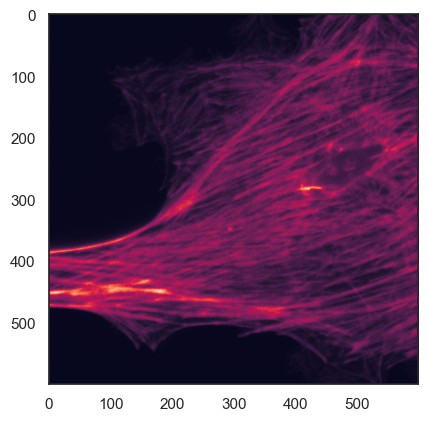

In [48]:
n_idx =2
sz=  600
hs =1000
ws=500

he=hs+sz#2500
we=ws+sz#2500
plt.imshow(gt[n_idx][hs:he,ws:we])

In [49]:
locations.append(Location(n_idx=n_idx, hs=hs, he=he, ws=ws, we=we))
locations

[Location(n_idx=40, hs=900, he=1500, ws=900, we=1500),
 Location(n_idx=0, hs=1250, he=1850, ws=1000, we=1600),
 Location(n_idx=1, hs=750, he=1350, ws=850, we=1450),
 Location(n_idx=2, hs=1000, he=1600, ws=700, we=1300),
 Location(n_idx=2, hs=1000, he=1600, ws=500, we=1100)]

In [50]:
def get_noise(shape):
    noise = np.random.rand(*shape) 
    noise =  noise/noise.std() * np.mean([img.std() for img in pred])
    noise = noise.astype(np.int32) - noise.mean() + pred.mean()
    return noise

def add_metric_text(ax, text, img_shape, place='TOP_LEFT', edgecolor='black'):
    """
    Adding text on image
    """
    assert place in ['TOP_LEFT', 'BOTTOM_RIGHT']
    if place == 'TOP_LEFT':
        ax.text(img_shape[1] * 15 / 300, img_shape[0] * 55 / 300, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.7))
    elif place == 'BOTTOM_RIGHT':
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 300, s1 - s1 * 35 / 300, text, bbox=dict(facecolor='white', edgecolor=edgecolor, alpha=0.7))


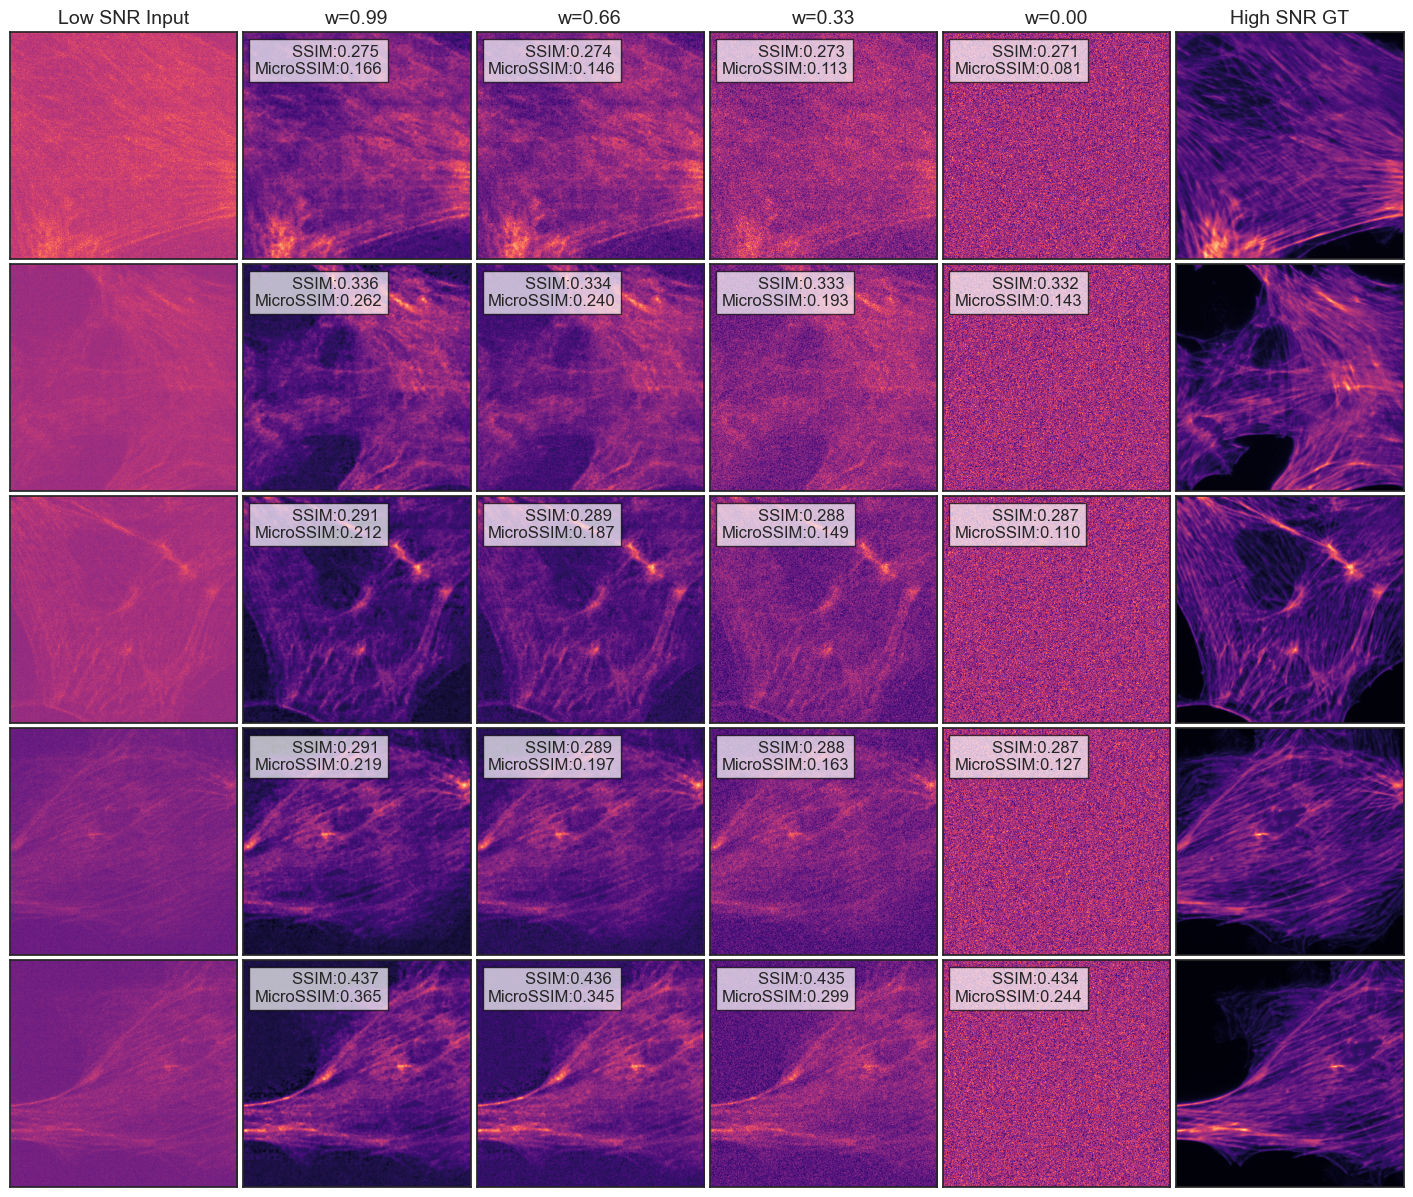

In [52]:
save_to_file = True and not debug_mode
alpha_list = np.arange(0,1.01,0.33)[::-1]
noise_as_pred = True
ncols = len(alpha_list) +2
nrows = len(locations)
_,ax = plt.subplots(figsize=(ncols*3,nrows*3), ncols=ncols, nrows=nrows)
for i, loc in enumerate(locations):
    gt_tmp = gt[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    gt_lowsnr_tmp = gt_lowsnr[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    pred_tmp = pred[loc.n_idx, loc.hs:loc.he, loc.ws:loc.we]
    
    if noise_as_pred:
        wrong_pred_tmp = get_noise(gt_tmp.shape)
    else:
        wrong_pred_tmp = pred[locations[(i+1)%2].n_idx, locations[(i+1)%2].hs:locations[(i+1)%2].he, locations[(i+1)%2].ws:locations[(i+1)%2].we]#
    
    ax[i,-1].imshow(gt_tmp, cmap='magma')
    ax[i,0].imshow(gt_lowsnr_tmp, cmap='magma')
    for j, alpha in enumerate(alpha_list):
        pred_alpha = pred_tmp*alpha + wrong_pred_tmp*(1-alpha)
        ax[i,j+1].imshow(pred_alpha, cmap='magma')
        if i ==0:
            ax[0,j+1].set_title(f'w={alpha:.2f}', fontsize=14)
        ssim_val = _compute_micro_ssim(gt_tmp , pred_alpha, ri_factor=1.0, 
                       data_range=gt_tmp.max() - gt_tmp.min(),
                       return_individual_components=False)

        microssim_val = msssim.score(gt_tmp, pred_alpha, return_individual_components=False)
        # ax[i,j+1].set_title(f'{alpha:.2f} {ssim_val:.2f} {microssim_val:.2f}')    
        add_metric_text(ax[i,j+1], f'        SSIM:{ssim_val:.3f}\nMicroSSIM:{microssim_val:.3f}', gt_tmp.shape, place='TOP_LEFT')

ax[0,0].set_title('Low SNR Input', fontsize=14)
ax[0,-1].set_title('High SNR GT', fontsize=14)
clean_ax(ax)
# reduce white space between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ablation_noise_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)